# Model Fitness

El presente es el análisis de la cadena de gimnasios Model Fitness de acuerdo a los perfiles digitales de sus clientes. 

El objetivo es elaborar una estrategia de retención de clientes, para lo cual predeciremos la probabilidad de pérdida del siguiente mes para cada cliente. 

## Preparación de los datos 

Vamos a preparar y limpiar nuestros datos, identificando duplicados y ausentes, así como conviertiendo datos al tipo de datos más útil para nuestro análisis.

### Cargar datos 

In [1]:
# Cargamos todas las librerías
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
# Cargamos el dataset
gym_churn = pd.read_csv('/datasets/gym_churn_us.csv')

### Descripción de datos

* 'Churn' — la cancelación para el mes en cuestión

**Datos del usuario del mes anterior:**
* 'Gender'. - género del usuario/a
* 'Near_Location' — si el/la usuario/a vive o trabaja en el vecindario donde se encuentra el gimnasio.
* 'Partner' — si el/la usuario/a trabaja en una compañía asociada (el gimnasio tiene empresas asociadas cuyos empleados obtienen descuentos; en esos casos el gimnasio almacena información sobre los empleadores de los clientes).
* Promo_friends — si el/la usuario/a originalmente se inscribió mediante una oferta “trae a un/a amigo/a” (se utilizó el código promocional de un/a amigo/a cuando pagaron el primer abono).
* 'Phone' — si el/la usuario/a aportó el número de teléfono.
* 'Age' - edad del usuario/a
* 'Lifetime' — el tiempo (en meses) desde que el/la usuario/a llegó por primera vez al gimnasio.

**Datos del registro de visitas y compras y datos sobre el estado actual de la membresía:**
* 'Contract_period' — 1 mes, 3 meses, 6 meses o 1 año.
* 'Month_to_end_contract' — los meses que faltan hasta que expire el contrato.
* 'Group_visits' — si el/la usuario/a participa en sesiones grupales.
* 'Avg_class_frequency_total' — frecuencia media de visitas por semana a lo largo de la vida del cliente.
* 'Avg_class_frequency_current_month' — frecuencia media de visitas por semana durante el mes en curso.
* 'Avg_additional_charges_total' — cantidad total de dinero gastado en otros servicios del gimnasio: cafetería, productos deportivos, cosméticos, masajes, etc.


In [3]:
# Imprimimos información general y verificamos si hay filas completamente duplicadas
gym_churn.info()
print(gym_churn.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

In [4]:
#Mostramos el DataFrame
display(gym_churn.head())

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


**Observaciones** 

* No tenemos datos ausentes en el DataFrame 
* No tenemos filas completamente duplicadas
* Todas nuestras columnas son variables binarias, excepto *Contract_period, Age,  Avg_additional_charges_total, Month_to_end_contract, Lifetime, Avg_class_frequency_total* y *Avg_class_frequency_current_month* 

## Análisis exploratorio de datos

In [5]:
gym_churn.describe()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


**Observaciones**

Después de analizar la media y desviación estándar podemos observar:
* Tenemos aproximadamente el mismo número mujeres y hombres 
* La mayoría de los usuarios viven cerca del gym 
* Casi la mitad de nuestros usuarios trabaja en una compañía asociada
* Menos de la mitad usó la  oferta de “trae a un/a amigo/a”
* La mayoría de nuestros usuarios brindó su número de teléfono
* La edad promedio de los usuarios es de 29 años
* El promedio de tiempo de los usuarios a partir que llegaron al gym es de 3 meses 
* El promedio de contrato es de 4 meses
* El promedio de meses que faltan para que termine el contrato es de 4 meses 
* Menos de la mitad participa en sesiones grupales 
* El promedio de visitas tanto este mes como en total es entre 1 y 2 por semana
* El promedio de gastos adicionales totales es de 146.9


In [6]:
# Observa los valores medios para las personas que se fueron (1) y para las que se quedaron (0)
average_churn = gym_churn.groupby('Churn').mean()
print(average_churn)

         gender  Near_Location   Partner  Promo_friends     Phone  \
Churn                                                               
0      0.510037       0.873086  0.534195       0.353522  0.903709   
1      0.510839       0.768143  0.355325       0.183789  0.902922   

       Contract_period  Group_visits        Age  Avg_additional_charges_total  \
Churn                                                                           
0             5.747193      0.464103  29.976523                    158.445715   
1             1.728558      0.268615  26.989632                    115.082899   

       Month_to_end_contract  Lifetime  Avg_class_frequency_total  \
Churn                                                               
0                   5.283089  4.711807                   2.024876   
1                   1.662582  0.990575                   1.474995   

       Avg_class_frequency_current_month  
Churn                                     
0                               2.0

**Observaciones**

Notamos que los usuarios que se quedaron: 
* Se encuentran más cerca dle gym que los que cancelaron 
* Tienen un promedio mayor tanto que si trabajan en una compañía asociada y usaron la oferta de “trae a un/a amigo/a”
* El contrato en promedio es de 5 meses, comparado que con los que cancelaron era de 1 mes
* En promedio tienen 29 años, comparado con los que cancelan que en promedio tienen 26 años
* Gastaron más en total 158 comparado con 115 de los que cancelaron 
* Les quedan 5 meses en su contrato , los que cancelaron 1 mes 
* Tienen 4 meses en promedio desde que iniciaron en el gym, los que cancelaron menos de 1 mes
* Tienen 2 visitas en promedio a la semana tanto en total como este último mes, los usuarios que cancelaron sólo 1 

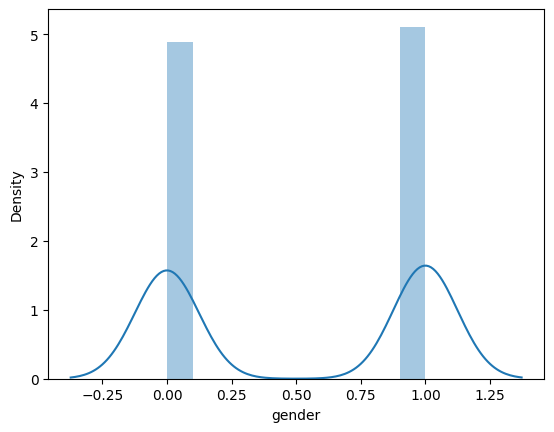

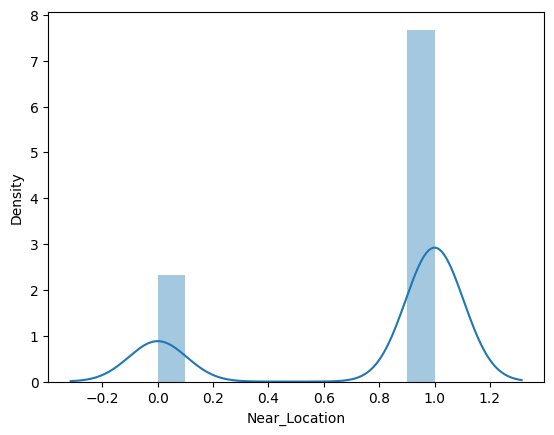

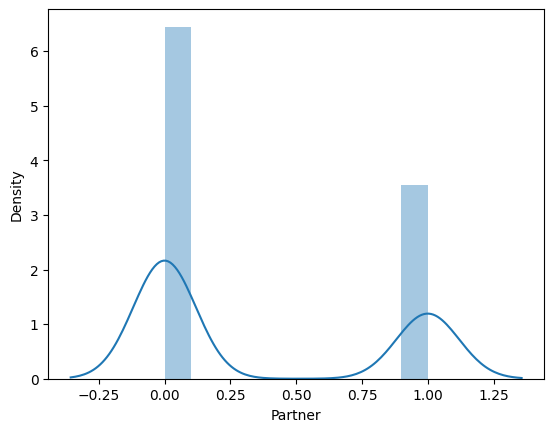

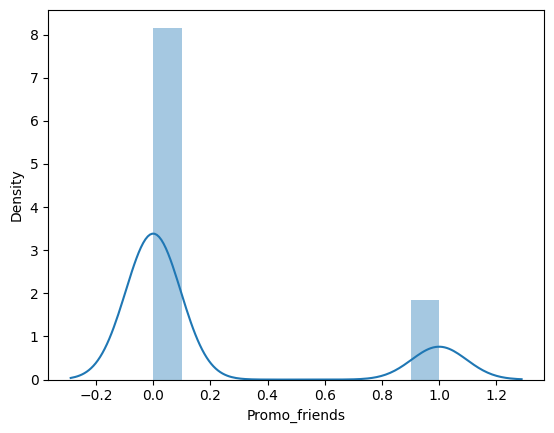

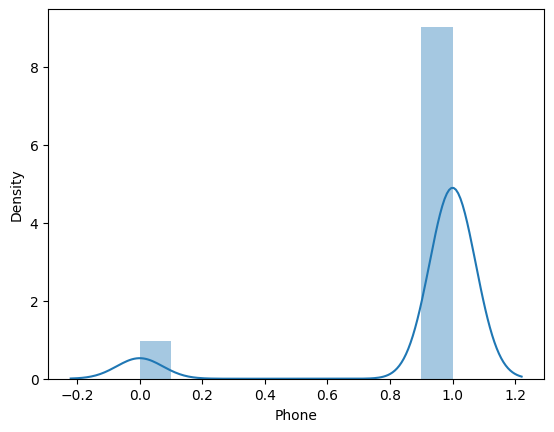

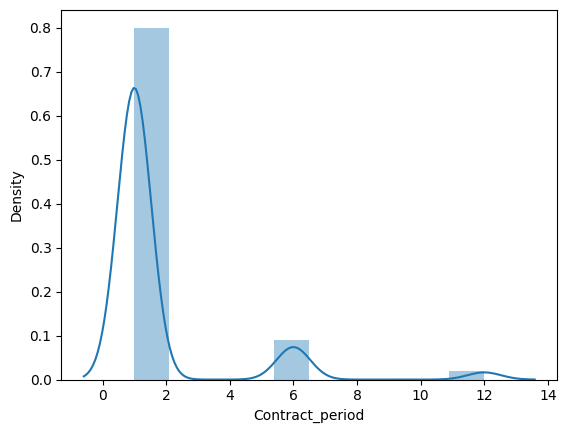

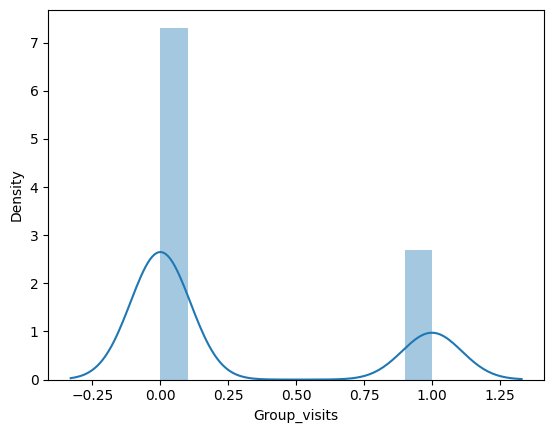

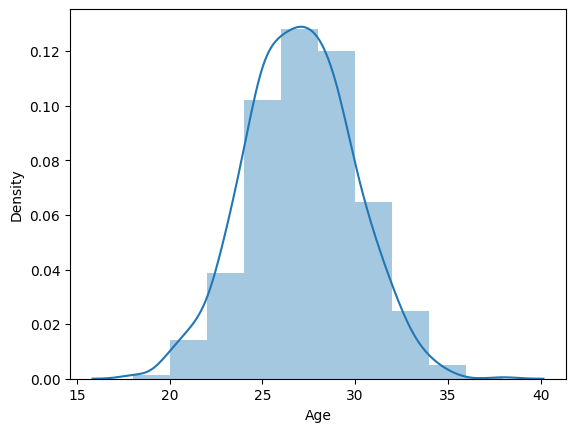

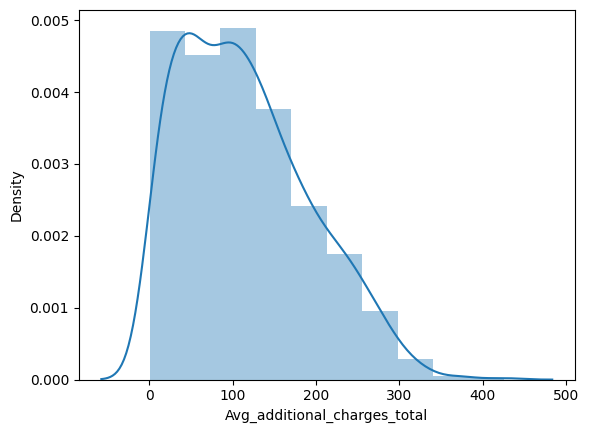

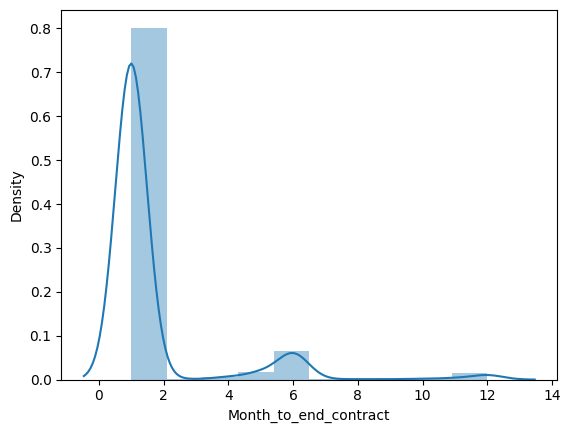

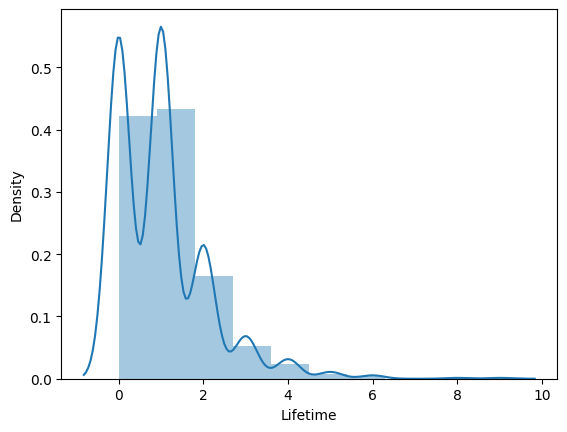

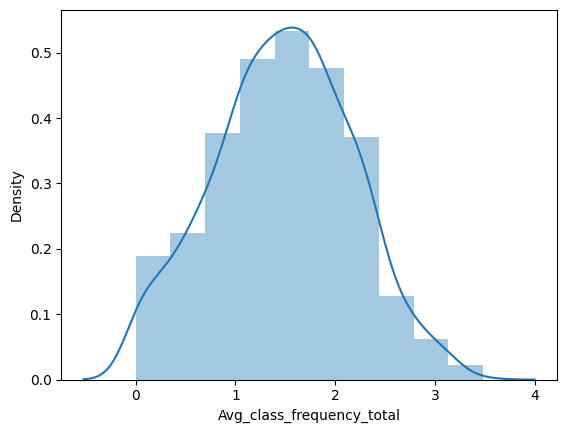

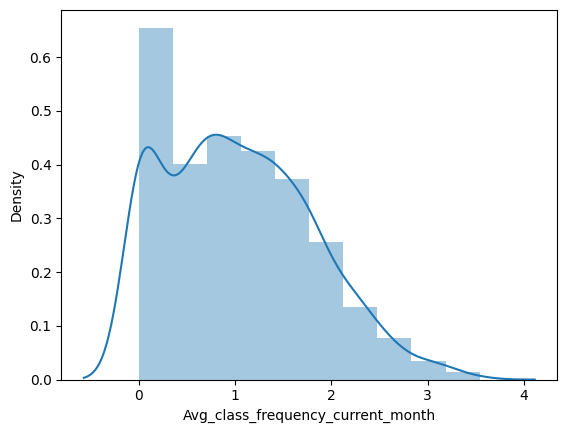

In [7]:
# Traza histogramas de barras y distribuciones de características para aquellas personas que cancelaron
cancelled_users = gym_churn.query("Churn == 1")
cancelled_users = cancelled_users.drop(labels=['Churn'],axis='columns') 

for feature in cancelled_users.columns:
  sns.distplot(cancelled_users[feature], bins = 10)
  plt.show()


**Observaciones**

De acuerdo a ambos histogramas de cada característica no observamos ningún sesgo o valor atípico obvio en los diagramas. 

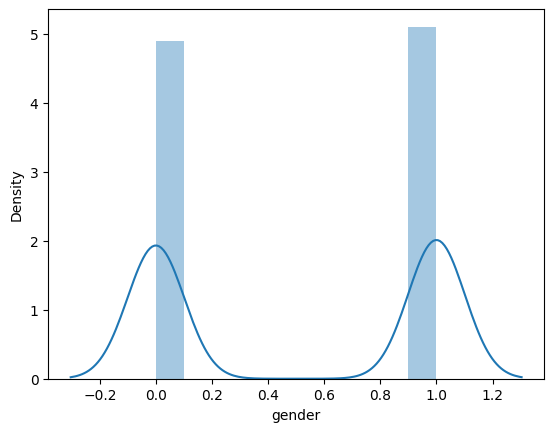

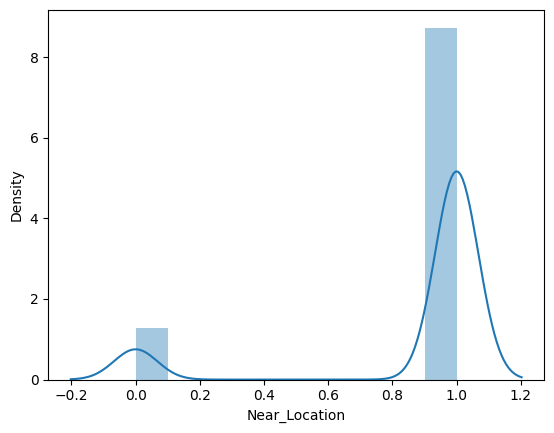

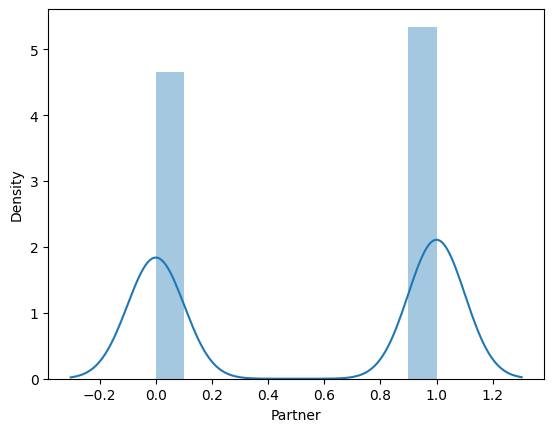

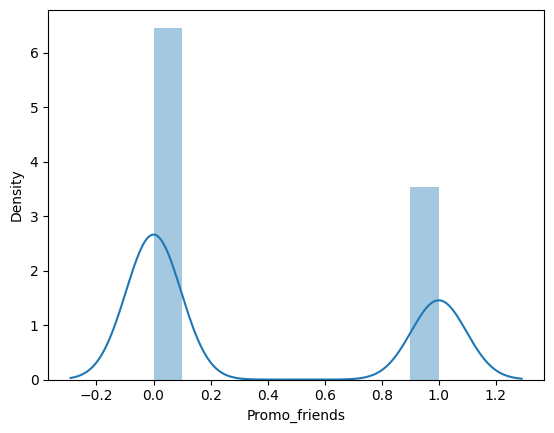

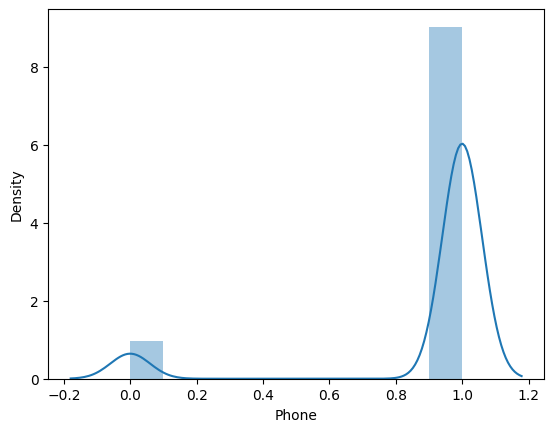

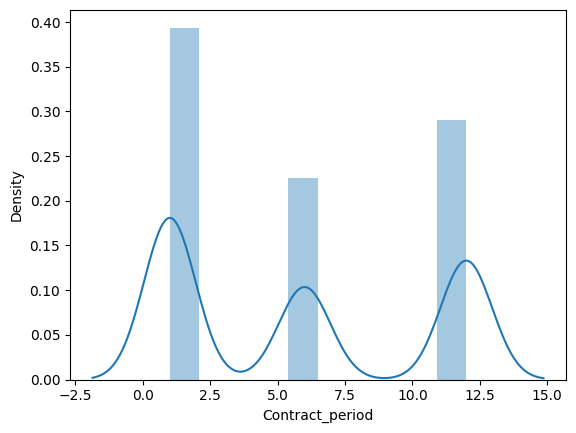

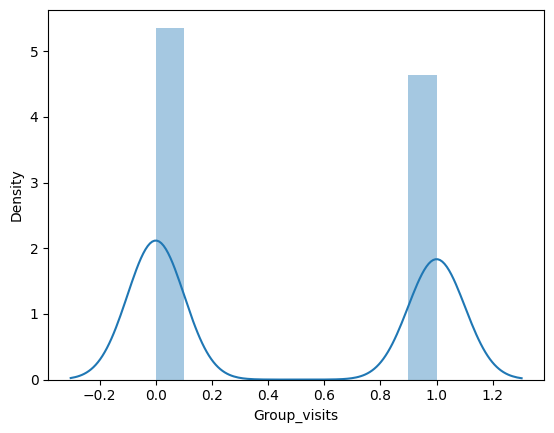

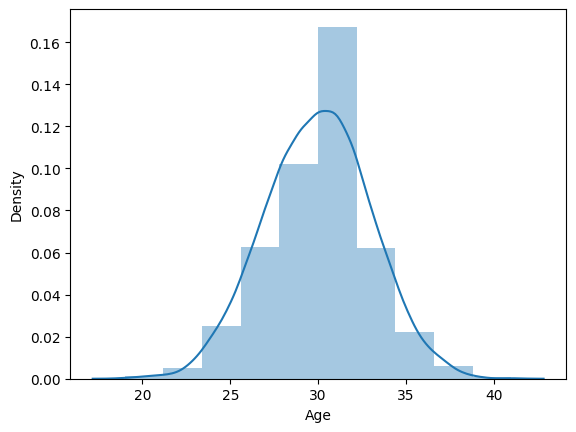

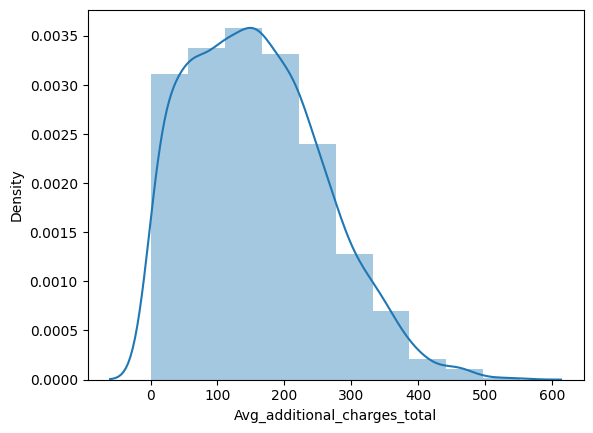

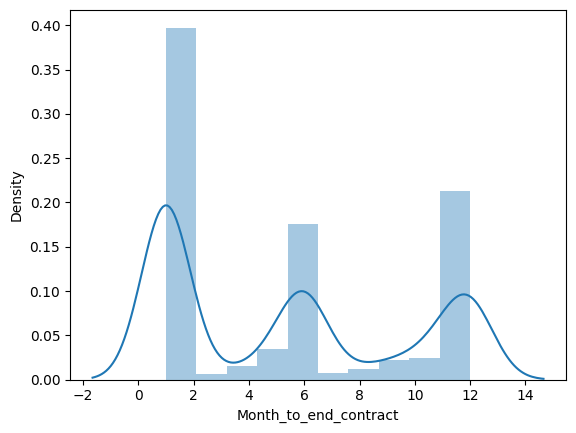

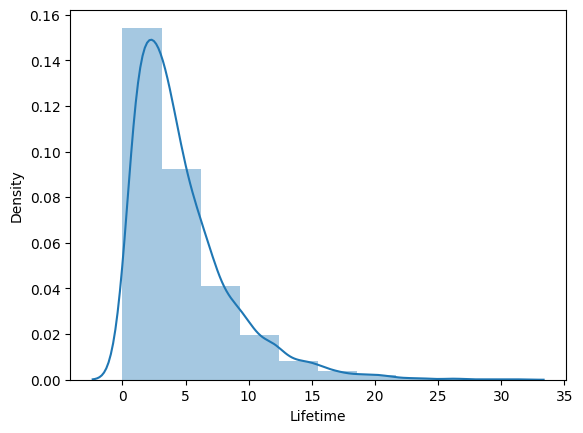

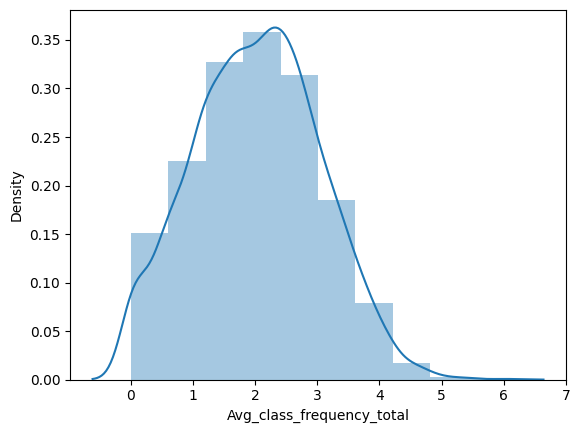

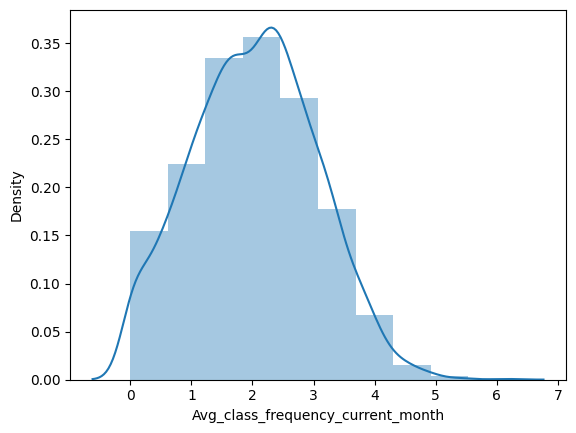

In [8]:
# # Traza histogramas de barras y distribuciones de características para aquellas personas que se quedaron
remaining_users = gym_churn.query("Churn == 0")
remaining_users = remaining_users.drop(labels=['Churn'],axis='columns') 

for feature in remaining_users.columns:
  sns.distplot(remaining_users[feature], bins = 10)
  plt.show()

**Observaciones**

De acuerdo a ambos histogramas de cada característica no observamos ningún sesgo o valor atípico obvio en los diagramas. 

<AxesSubplot:>

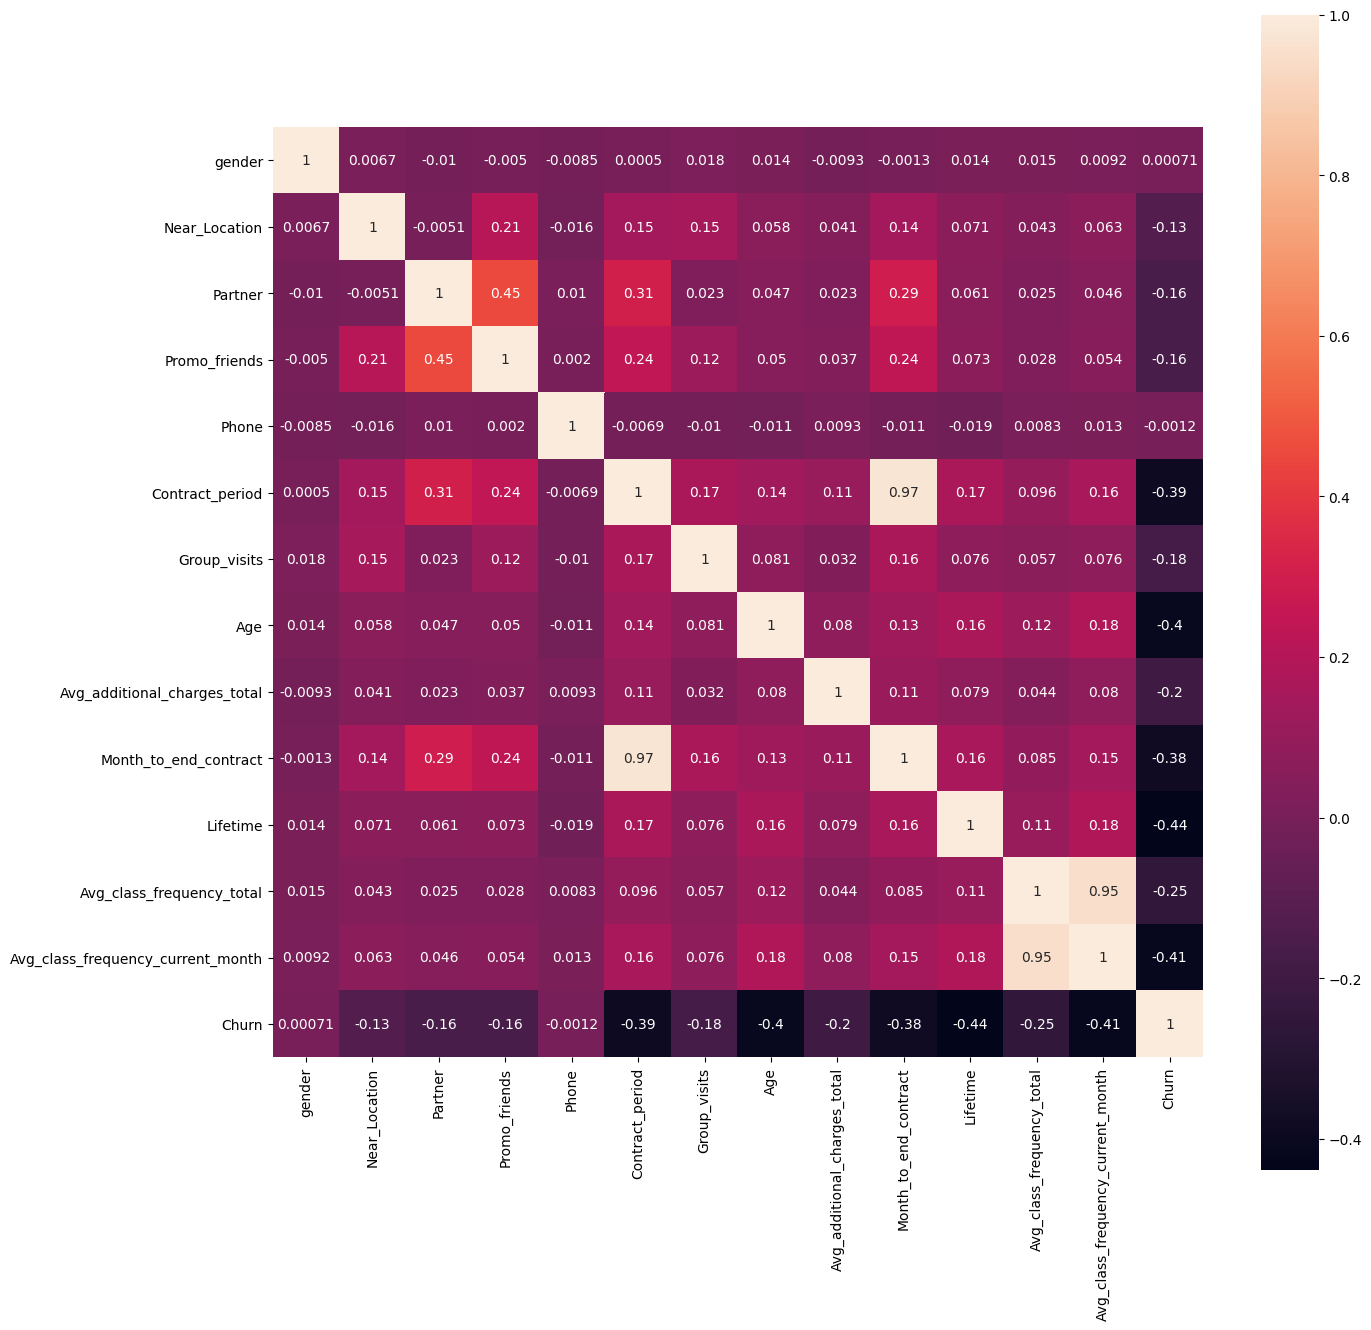

In [9]:
# Creamos una matriz de correlación y la mostramos con un mapa de calor  
corr_churn = gym_churn.corr()
plt.figure(figsize=(15, 15))
sns.heatmap(
    corr_churn,
    square=True,
    annot=True,)

**Observaciones**
* Notamos una correlación fuerte entre *Contract_period* y *Month_to_end_contract*, así como *Avg_class_frequency_total* y *Avg_class_frequency_current_month* siendo bastante parecidas entre sí
* De igual forma entre *Partner* y *Promo_friends*, aunque no tan fuerte, pero al ser un beneficio/oferta de usuario tiene sentido

## Construcción de modelo

In [10]:
# Dividimos nuestros datos en características y nuestra variable objetivo
X = gym_churn.drop('Churn', axis=1)
y = gym_churn['Churn']

#Dividimos los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=0)

#Creamos un objeto StandardScaler y lo aplicamos al conjunto de entrenamiento
scaler = StandardScaler()

#Entrenamos el scaler y transformamos la matriz para el conjunto de entrenamiento
X_train_st = scaler.fit_transform(X_train)

#Aplicamos la estandarización a la matriz de característica para el test de prueba
X_test_st = scaler.transform(X_test)

### Regresión logística

In [11]:
#Entrenamos el modelo con el set de entrenamiento para Regresión logística
logic_model = LogisticRegression()

#Entrenamos el modelo
logic_model.fit(X_train_st, y_train)

#Utilizamos el modelo entrenado para hacer una predicción
logic_predictions = logic_model.predict(X_test_st)

print('Exactitud: {:.2f}'.format(accuracy_score(y_test,logic_predictions)))
print('Precisión: {:.2f}'.format(precision_score(y_test, logic_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, logic_predictions)))

Exactitud: 0.92
Precisión: 0.85
Recall: 0.83


### Bosque aleatorio

In [12]:
#Entrenamos el modelo con el set de entrenamiento para Bosque aleatorio
forest_model = RandomForestClassifier(n_estimators = 100, random_state=0)

#Entrenamos el modelo
forest_model.fit(X_train_st, y_train)

#Utilizamos el modelo entrenado para hacer una predicción
forest_predictions = forest_model.predict(X_test_st)

print('Exactitud: {:.2f}'.format(accuracy_score(y_test,forest_predictions)))
print('Precisión: {:.2f}'.format(precision_score(y_test, forest_predictions)))
print('Recall: {:.2f}'.format(recall_score(y_test, forest_predictions)))

Exactitud: 0.92
Precisión: 0.84
Recall: 0.81


**Observaciones**
* Ambos tienen el misma exactitud
* La regresión lógica tiene mayor precisión y recall

Por lo anterior podemos concluir que Regresión lógica dio mejores resultados

## Clustering

### Dendograma

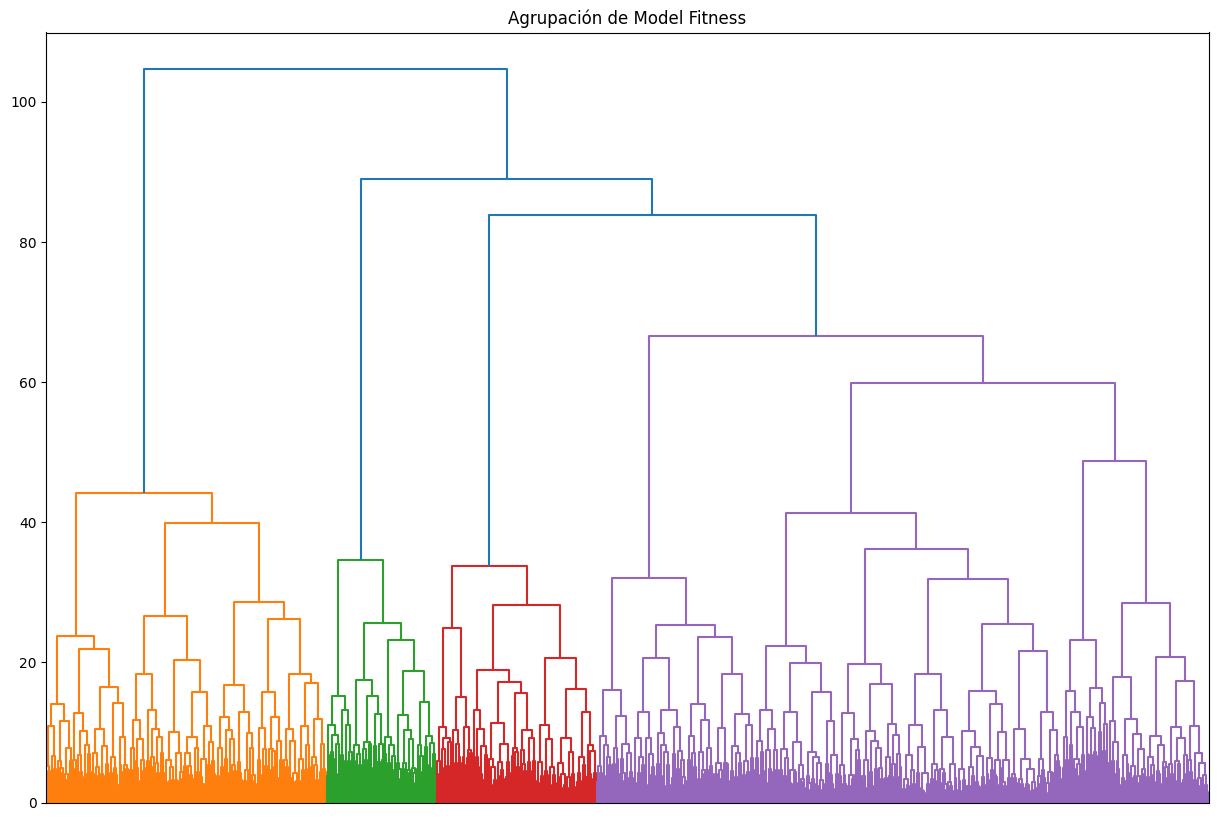

In [13]:
#Trazamos un dendograma
cluster = scaler.fit_transform(X)
linked = linkage(cluster, method = 'ward')
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top', no_labels=True)
plt.title('Agrupación de Model Fitness')
plt.show()


**Observaciones**

El número óptimo de clústeres sugerido es de 4

### K-means

In [14]:
# Entrenamos el modelo con el algoritmo K-means
km_model = KMeans(n_clusters = 5, random_state =0)

#Predecimos los clústeres para las observaciones
labels = km_model.fit_predict(cluster)

#Agregamos las etiquetas al DataFrame
gym_churn['cluster_km'] = labels 


#Obtenemos las estadísticas de los valores medios de las características por clúster
mean_cluster = gym_churn.groupby('cluster_km').mean()
print(mean_cluster)

              gender  Near_Location   Partner  Promo_friends     Phone  \
cluster_km                                                               
0           0.502970       0.959406  0.783168       0.574257  1.000000   
1           0.522078       0.862338  0.470130       0.306494  0.000000   
2           0.495050       0.000000  0.463366       0.079208  1.000000   
3           0.485737       1.000000  0.350238       0.240095  1.000000   
4           0.559666       0.976134  0.356802       0.230310  0.998807   

            Contract_period  Group_visits        Age  \
cluster_km                                             
0                 10.889109      0.542574  29.982178   
1                  4.787013      0.425974  29.301299   
2                  2.352475      0.215842  28.477228   
3                  1.948494      0.341521  28.167987   
4                  2.669451      0.473747  30.125298   

            Avg_additional_charges_total  Month_to_end_contract  Lifetime  \
cluster_km 

**Observaciones**
* En cuanto a características especificas para distinguir un cluster de otro: 
    * El **0** es el que tiene menor promedio en churn, tienen 9 meses para que termine el contrato y su periodo de contrato es de 10 meses, en mayoría tabajan en una compañía asociada 
    * El **1** no dejaron teléfono, su periodo de contrato y los meses restantes son 4 meses
    * El **2** son usuarios que no están cerca del gym, son los que menos usaron la oferta de "trae a un/una amigo/a"
    * El **3** es el que tiene mayor promedio en churn, en promedio todos los usuarios viven cerca del gym, tienen el menor número de meses de contrato y meses restantes en su contrato, siendo ambos casos 1, son los que gastan menos, y tienen menos promedio de clases totales y en este mes
    * El **4** es el de mayor promedio de edad con 30 años, el mayor promedio de gasto total de 162 y el mayor número de clases totales y este mes, siendo 2. De igual forma tiene un valor bajo en churn

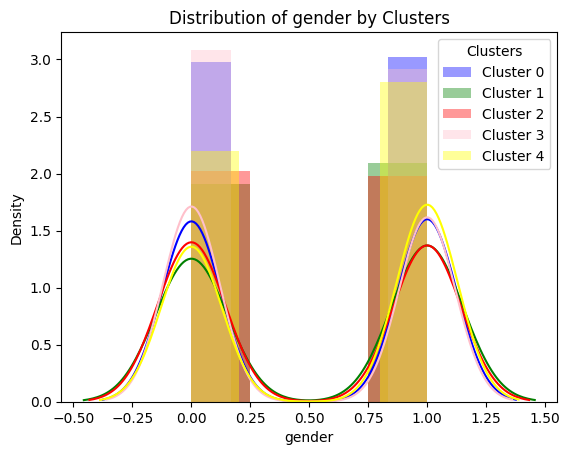

/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/python3/lib/python3.9/site-packages/seaborn/distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


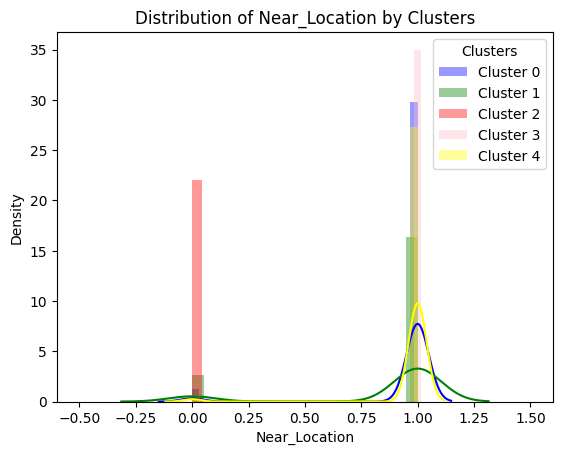

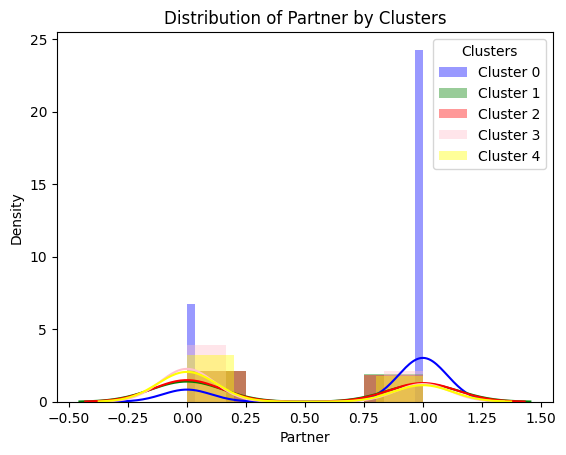

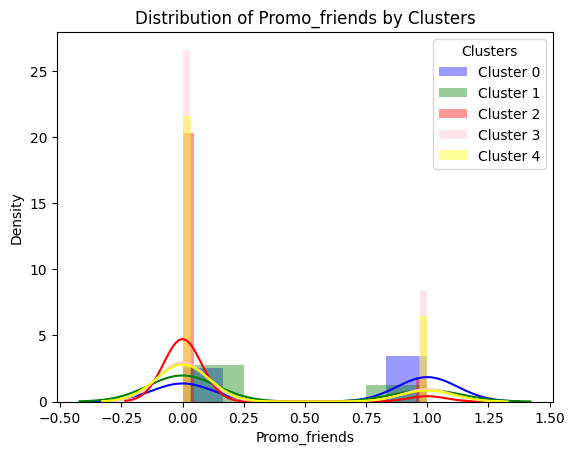

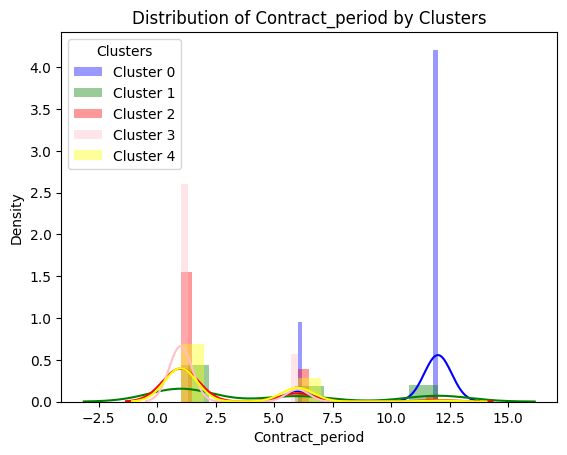

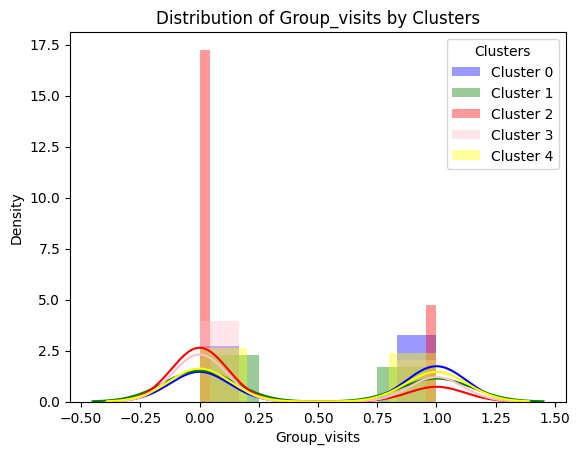

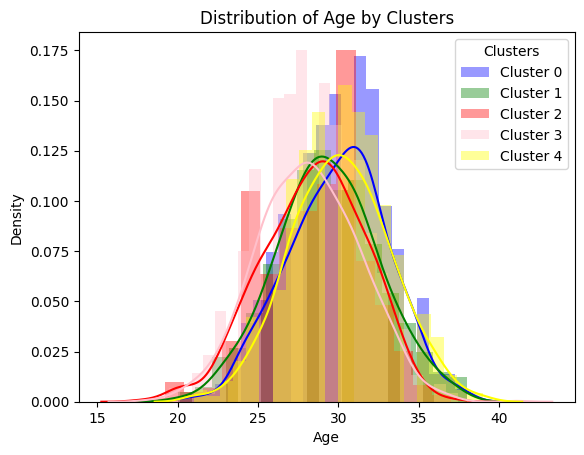

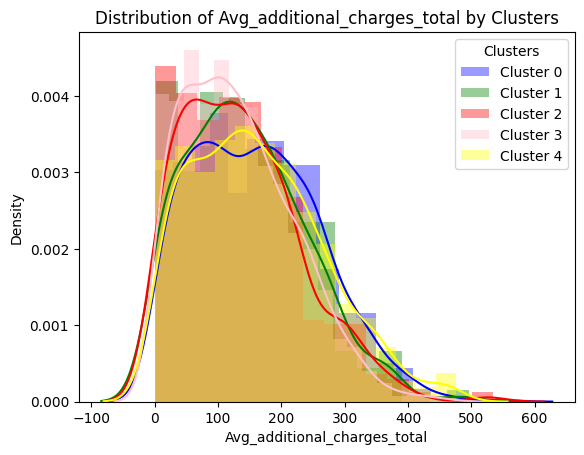

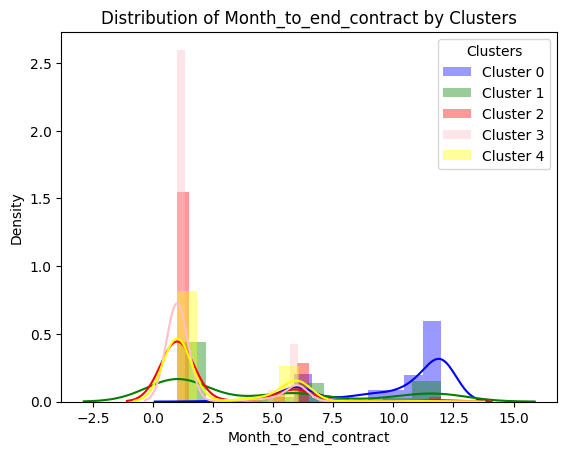

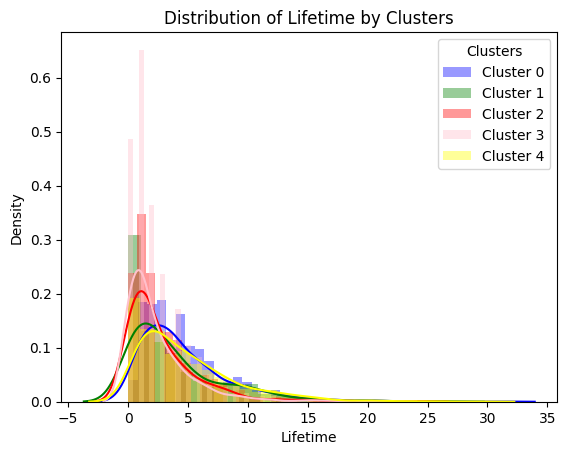

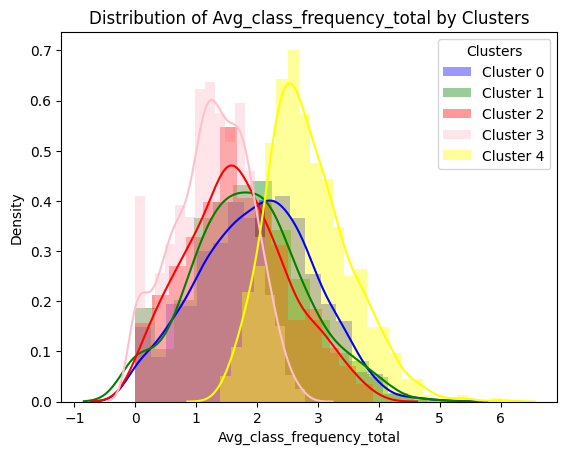

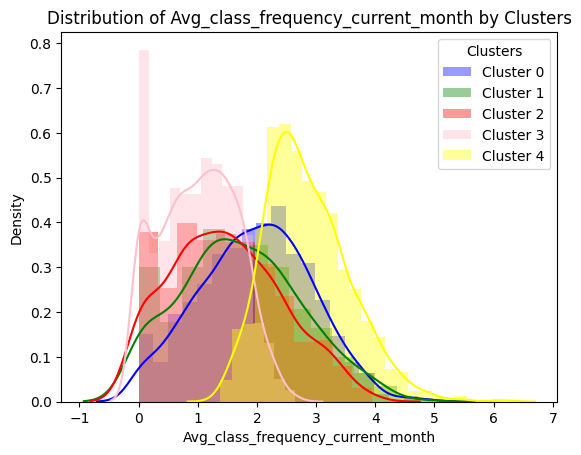

In [17]:
#Trazamos distribuciones de características para los clústeres
for col in gym_churn.drop(['cluster_km','Churn','Phone'], axis=1).columns:
    sns.distplot(gym_churn[gym_churn['cluster_km'] == 0][col], label='Cluster 0', color='blue')
    sns.distplot(gym_churn[gym_churn['cluster_km'] == 1][col], label='Cluster 1', color='green')
    sns.distplot(gym_churn[gym_churn['cluster_km'] == 2][col], label='Cluster 2', color='red')
    sns.distplot(gym_churn[gym_churn['cluster_km'] == 3][col], label='Cluster 3', color='pink')
    sns.distplot(gym_churn[gym_churn['cluster_km'] == 4][col], label='Cluster 4', color='yellow')
    plt.legend(title='Clusters')
    plt.title(f'Distribution of {col} by Clusters')
    plt.show()


**Observaciones**
* Tanto *gender, Partner, Promo_friends* y *Group_visits* tienen una misma distribución en cada cluster y si es 0 o 1, sin embargo tenemos datos atípicos en diferentes clusters. 
* En *Near_location* el cluster 3 tiene valores atípicos en 0, pero en general los demás clusters tienen en su mayoría valores en 1
* *Phone* sólo tiene valores en 0 para el cluster 0, el resto de los clusters se encuentran en 1
* El cluster 0 no tiene usuarios que su contrato sea de 1 mes, en mayoría están en 6 y 12 meses, teniendo su mayoría 12 meses
* El cluster 2 tiene un gran número de usuarios que no tomaron clases en grupo


### Tasa de cancelación

In [16]:
tasa_xld = gym_churn.groupby('cluster_km')['Churn'].mean()
print(tasa_xld)

cluster_km
0    0.027723
1    0.267532
2    0.443564
3    0.514263
4    0.068019
Name: Churn, dtype: float64


**Observaciones**
* Los grupos con menor tasa de cancelación son los clusters **0** y **1** son más leales y propensos a quedarse
* Los grupos con mayor tasa de cancelación son el **3** y **2**

## Conclusiones

* Si los usuarios sólo contratan 1 mes, es muy probable que cancelen
* Si a los usuarios sólo les resta 1 mes, es muy probable que cancelen y que no extiendan su membresía
* Si no están cerca del gym, es probable que cancelen 
* Entre los usuarios más leales son los que trabajan en una compañía asociada

De acuerdo al análisis anterior, sugerimos lo siguiente: 
* Hacer difusión de las clases que se ofrecen, para motivar a que los usuarios tengan más de 1 visita a la semana
* Promover el beneficio de la membresía con las compañías asociadas, talvez poniendo como mínimo de contrato 3 meses, para evitar la cancelación al primer mes
* Hacer mayor promoción a la oferta de "trae un/a amigo/a", ya que los que no formaron parte de la oferta fueron más propensos a cancelar
* Hacer difusión cerca del gym para atraer a la gente a los alrededores